In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.metrics import  roc_curve, auc, precision_recall_curve



In [47]:
df = pd.read_csv("ADASYN training_dataset.csv")


In [2]:
df = pd.read_csv("Dataset.csv")

In [3]:
df = df.drop(columns=["Unnamed: 0", "DATE"], errors="ignore")

In [11]:
imputer = SimpleImputer(strategy="mean")
df[df.columns] = imputer.fit_transform(df)

In [5]:
df['Ava_date'].value_counts()

Ava_date
0.0    4227
1.0    1252
Name: count, dtype: int64

In [6]:
df_test = pd.read_csv("test_set.csv")

In [7]:
df_test = df_test.drop(columns=["Unnamed: 0", "DATE"], errors="ignore")

In [12]:
imputer = SimpleImputer(strategy="mean")
df_test[df_test.columns] = imputer.fit_transform(df_test)

In [13]:
df_test['Ava_date'].value_counts()

Ava_date
0.0    846
1.0    250
Name: count, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Maximum_humidity_              5479 non-null   float64
 1   Average_humidity_              5479 non-null   float64
 2   Minimum_humidity_              5479 non-null   float64
 3   Precipitation_mm               5479 non-null   float64
 4   Average_temperature_C          5479 non-null   float64
 5   Maximum_temperature_C          5479 non-null   float64
 6   Minimum_temperature_C          5479 non-null   float64
 7   Heating_Degree_Days_Base_20_C  5479 non-null   float64
 8   Heating_Degree_Days_base_18_C  5479 non-null   float64
 9   Cooling_Degree_Days_Base_21_C  5479 non-null   float64
 10  Average_speed_ms               5479 non-null   float64
 11  Gust_speed_ms                  5479 non-null   float64
 12  Stay_time_min                  5479 non-null   f

In [15]:
X_train = df[['Maximum_humidity_', 'Average_humidity_', 'Minimum_humidity_',
       'Precipitation_mm', 'Average_temperature_C', 'Maximum_temperature_C',
       'Minimum_temperature_C',
       'Average_speed_ms', 'Gust_speed_ms', 'Stay_time_min',
       'Calm_duration_min']]
y = df['Ava_date']

In [16]:
X_test = df_test[['Maximum_humidity_', 'Average_humidity_', 'Minimum_humidity_',
       'Precipitation_mm', 'Average_temperature_C', 'Maximum_temperature_C',
       'Minimum_temperature_C',
       'Average_speed_ms', 'Gust_speed_ms', 'Stay_time_min',
       'Calm_duration_min']]
y_test = df_test['Ava_date']

In [80]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [204]:
# Get best parameters
best_params = {
    'n_estimators': 500,       
    'max_depth': 12,          
    'min_samples_split':10,
    'criterion': 'gini',
    'min_samples_leaf': 2,
    'bootstrap': False}

# Train Model
rf_model = RandomForestClassifier(**best_params, random_state=42)
rf_model.fit(X_train, y)



RandomForestClassifier(bootstrap=False, max_depth=12, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=500, random_state=42)

In [216]:
# Get best parameters
best_params = {
    'n_estimators': 500,       
    'max_depth': 11,          
    'min_samples_split':10,
    'criterion': 'gini',
    'min_samples_leaf': 2,
    'bootstrap': False,
    'class_weight': {0: 1, 1: 5} 
    }

# Train Model
rf_model = RandomForestClassifier(**best_params, random_state=42)
rf_model.fit(X_train, y)



RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 5}, max_depth=11,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=500, random_state=42)

In [227]:
from sklearn.metrics import f1_score

# Thresholds to try
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores_class1 = []

for t in thresholds:
    y_pred = (y_prob > t).astype(int)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    f1_scores_class1.append(f1)

# Find threshold that maximizes F1 for minority class
best_threshold = 0.744
y_pred_adj = (y_prob > best_threshold).astype(int)

print(f"Chosen threshold for optimizing class 1 F1: {best_threshold}")

Chosen threshold for optimizing class 1 F1: 0.744


In [230]:
# Final Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_adj))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       846
         1.0       0.79      0.92      0.85       250

    accuracy                           0.92      1096
   macro avg       0.88      0.92      0.90      1096
weighted avg       0.93      0.92      0.93      1096



In [ ]:
cm = confusion_matrix(y_test,y_pred_adj)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=rf_model.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", ax=ax, values_format=".2f") 

plt.title("Normalized Confusion Matrix (%)")
plt.show()

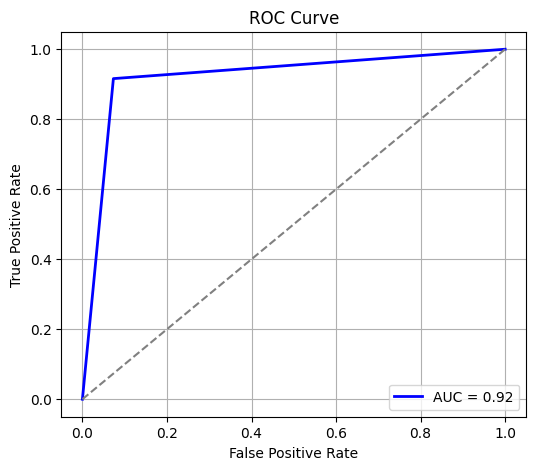

In [231]:
cm = confusion_matrix(y_test, y_pred_adj)
fpr, tpr, _ = roc_curve(y_test, y_pred_adj)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

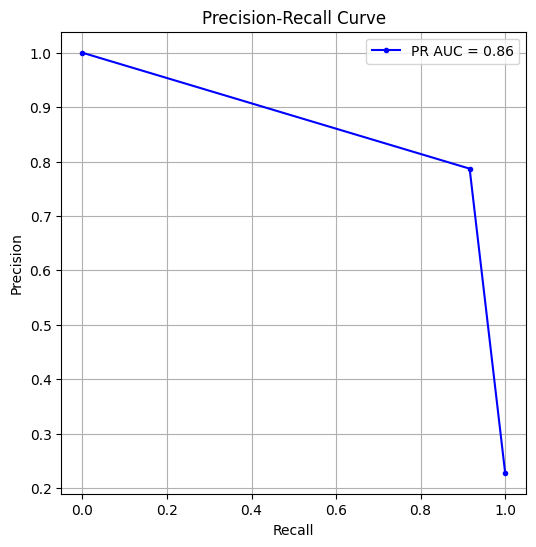

In [232]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_adj)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.2f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


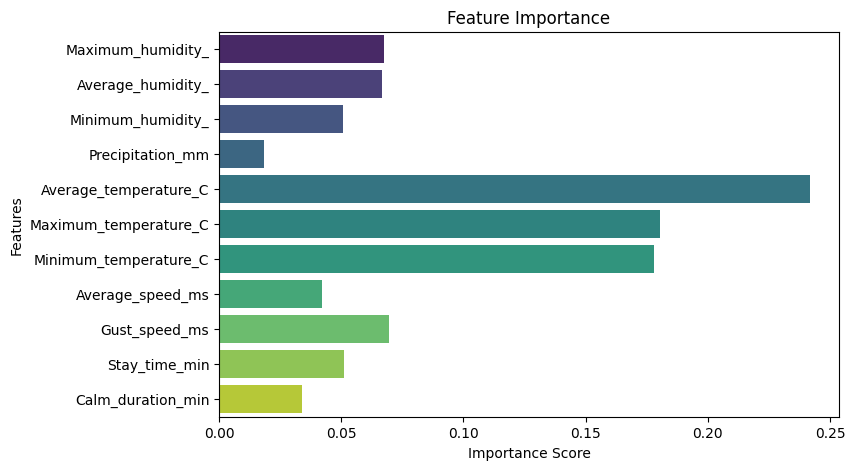

In [87]:
feature_importance = rf_model.feature_importances_
feature_names = ['Maximum_humidity_', 'Average_humidity_', 'Minimum_humidity_',
       'Precipitation_mm', 'Average_temperature_C', 'Maximum_temperature_C',
       'Minimum_temperature_C',
       'Average_speed_ms', 'Gust_speed_ms', 'Stay_time_min',
       'Calm_duration_min'] 

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance, y=feature_names, palette='viridis')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

/var/folders/pf/s5rt_fz51d7d1r631_mnbzs40000gn/T/ipykernel_21614/1645328094.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_prob_0, shade=True, color="blue", label="True Class 0", bw_adjust=0.5)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/pf/s5rt_fz51d7d1r631_mnbzs40000gn/T/ipykernel_21614/1645328094.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_prob_1, shade=True, color="green", label="True Class 1", bw_adjust=0.5)
/Library/Frameworks/Python.framework/Versions/

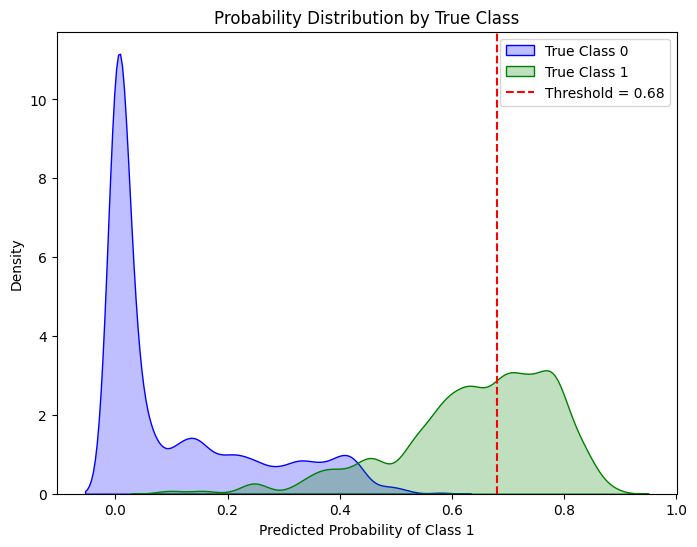

In [88]:
y_prob_0 = y_prob[y_test == 0]
y_prob_1 = y_prob[y_test == 1] 


plt.figure(figsize=(8,6))
sns.kdeplot(y_prob_0, shade=True, color="blue", label="True Class 0", bw_adjust=0.5)
sns.kdeplot(y_prob_1, shade=True, color="green", label="True Class 1", bw_adjust=0.5)

plt.axvline(x=0.68, color='red', linestyle="--", label="Threshold = 0.68")
plt.xlabel("Predicted Probability of Class 1")
plt.ylabel("Density")
plt.title("Probability Distribution by True Class")
plt.legend()
plt.show()

In [89]:
df_new.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)

NameError: name 'df_new' is not defined

In [ ]:
df_new.to_csv("dataset v1.csv", index=False)

In [ ]:
df_new['DATE'] = pd.to_datetime(df_new['DATE'])

# Set 'DATE' as the index
df_new.set_index('DATE', inplace=True)

In [ ]:
title='Probability of Avalanche occurence'
ylabel= "Probability"
xlabel='Year'
ax = df_new['Ava_proba'].plot(figsize=(18,10),title=title, color='blue')
ax.autoscale(axis='x',tight=False)
ax.set(xlabel=xlabel, ylabel=ylabel);


NameError: name 'df_new' is not defined

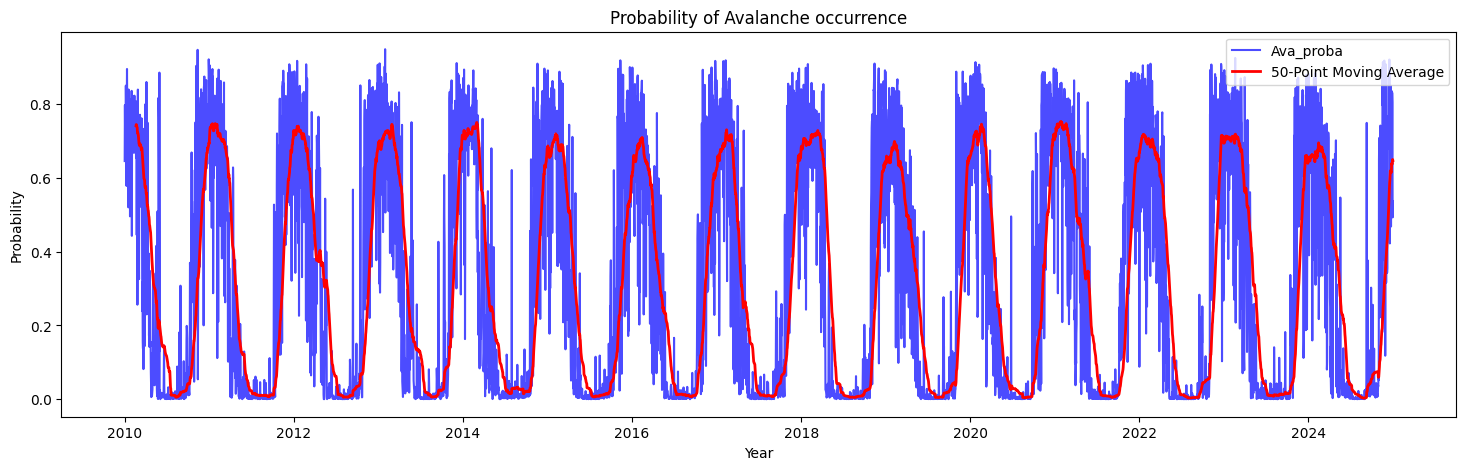

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử df_new là DataFrame của bạn và 'Ava_proba' là cột chứa giá trị xác suất.
# Tính toán moving average (ví dụ: cửa sổ 7)
window_size = 50
df_new['Ava_proba_MA'] = df_new['Ava_proba'].rolling(window=window_size).mean()

# Vẽ đồ thị
title = 'Probability of Avalanche occurrence'
ylabel = "Probability"
xlabel = 'Year'

fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(df_new['Ava_proba'], color='blue', alpha=0.7, label='Ava_proba')
ax.plot(df_new['Ava_proba_MA'], color='red', label=f'{window_size}-Point Moving Average', linewidth=2)

ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
ax.autoscale(axis='x', tight=False)
ax.legend(loc='best')

plt.show()

In [ ]:
df_new.columns

Index(['Maximum_humidity_', 'Average_humidity_', 'Minimum_humidity_',
       'Precipitation_mm', 'Average_temperature_C', 'Maximum_temperature_C',
       'Minimum_temperature_C', 'Heating_Degree_Days_Base_20_C',
       'Heating_Degree_Days_base_18_C', 'Cooling_Degree_Days_Base_21_C',
       'Average_speed_ms', 'Gust_speed_ms', 'Stay_time_min',
       'Calm_duration_min', 'Ava_date', 'Ava_proba', 'Ava_proba_MA'],
      dtype='object')

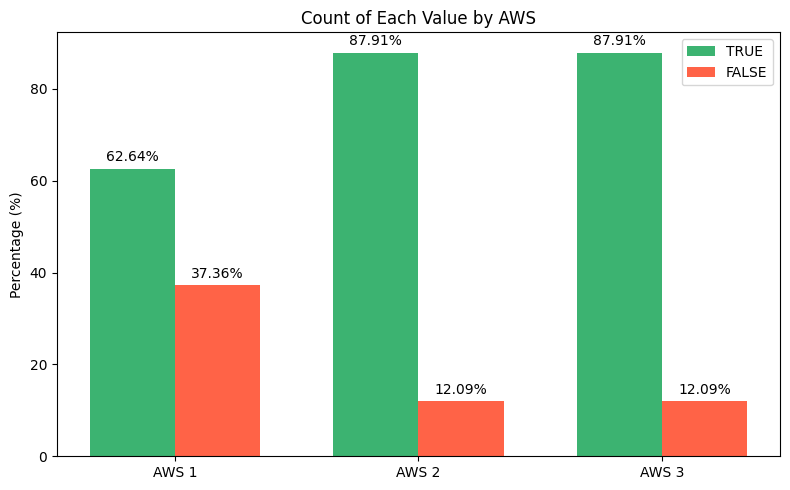

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ["AWS 1", "AWS 2", "AWS 3"]
true_values = [62.64,	87.91,	87.91]
false_values = [37.36,12.09,	12.09]

x = np.arange(len(categories))  # label positions
width = 0.35  # width of each bar

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, true_values, width, label='TRUE', color='mediumseagreen')
bars2 = ax.bar(x + width/2, false_values, width, label='FALSE', color='tomato')

# Add labels and title
ax.set_ylabel('Percentage (%)')
ax.set_title('Count of Each Value by AWS')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add percentage labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()